In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers
!pip install datasets
!pip install stanza
!pip install Sastrawi
!pip install wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 52.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 45.7 MB/s eta 0:00:00
  

# Library

In [ ]:
import pandas as pd
import numpy as np
import re
import string
import stanza
from collections import Counter
from tqdm import tqdm
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.metrics.pairwise import cosine_similarity
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import LabelEncoder
import nltk
from collections import Counter
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch.nn.functional as F
from sklearn.cluster import KMeans
import torch
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
from datasets import Dataset
from torch.utils.data import TensorDataset
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import  accuracy_score
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score
from sklearn.metrics import confusion_matrix

## Function

In [ ]:
def create_corpus(data, var):
    corpus = []
    for x in data[var].str.split():
        for i in x:
            corpus.append(i)
    return corpus

# Get data containing specific word function
def get_data_contains_word(data, feature, string):
    _id = []
    for text, ID in zip(data[feature], data['review_id']):
        if string in text:
            _id.append(ID)
    return data[data['review_id'].isin(_id)]

# Remove Indonesian stop words using Sastrawi
def remove_indonesian_stop(data, feature):
    factory = StopWordRemoverFactory()
    stopwords = set(factory.get_stop_words())
    filtered = []
    for text in data[feature]:
        text_list = [word for word in text.split() if word not in stopwords]
        filtered.append(' '.join(text_list))
    return filtered

# Plotting words containing specific word function
def docs_contain_word_plot(data, var, num_words, width, height):
    words, counts = [], []
    corpus = list(set(create_corpus(data, var)))
    for word in tqdm(corpus):
        words.append(word)
        counts.append(get_data_contains_word(data, var, word).shape[0])
    res = pd.DataFrame({'words': words, 'counts': counts}).sort_values(by='counts', ascending=False)
    plt.figure(figsize=[width, height])
    sns.barplot(data=res.iloc[:num_words], x='counts', y='words')
    for index, value in enumerate(res['counts'].iloc[:num_words]):
        plt.text(value, index, value)
    plt.show()

# Count numerical occurrences function
def num_count(data, feature):
    num_list = []
    for sentence in tqdm(data[feature]):
        num = sum(1 for word in sentence if word.isdigit())
        num_list.append(num)
    return num_list

# Count numerical occurrences function
def num_count(data, feature):
    num_list = []
    for sentence in tqdm(data[feature]):
        num = sum(1 for word in sentence if word.isdigit())
        num_list.append(num)
    return num_list

# Plot unique word count function
def plot_unique_word_count(corpus, width, height, range1, range2, title, color, ax=None):
    words, values, len_words = [], [], []
    for word, value in zip(pd.DataFrame(corpus).value_counts().index, pd.DataFrame(corpus).value_counts()):
        words.append(word[0])
        values.append(value)
        len_words.append(len(word[0]))
    res = pd.DataFrame({'words': words, 'values': values, 'len_words': len_words}).sort_values(by='values', ascending=False)
    ax = ax
    ax.set_title(title)
    sns.barplot(data=res[range1:range2], y='words', x='values', color=color, ax=ax)
    for index, value in enumerate(res['values'].iloc[range1:range2]):
        plt.text(value, index, value)
    return ax

# Generate dataframe of unique word count function
def df_unique_word_count(corpus):
    words, values, len_words = [], [], []
    for word, value in zip(pd.DataFrame(corpus).value_counts().index, pd.DataFrame(corpus).value_counts()):
        words.append(word[0])
        values.append(value)
        len_words.append(len(word[0]))
    return pd.DataFrame({'words': words, 'values': values, 'len_words': len_words}).sort_values(by='values', ascending=False)

# word cloud
def plot_word_cloud(corpus, title, ax):
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(corpus)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(title, fontsize=18, weight='bold')
    ax.axis('off')

## Typo dictionary

In [ ]:
words_dict = {
    '1000gb': '1000 GB',
    '10gb': '10 GB',
    '20gb': '20 GB',
    '247gb': '247 GB',
    '2nd': 'kedua',
    '30mnt': '30 menit',
    '5ghz': '5 GHz',
    'Basecamp': 'kem',
    'aamiin': 'amin',
    'absen': 'ketidakhadiran',
    'absensi': 'daftar hadir',
    'acara': 'program',
    'acc': 'terima',
    'access': 'akses',
    'account': 'akun',
    'acnya': 'ac nya',
    'ad': 'ada',
    'adain': 'adakan',
    'adem': 'sejuk',
    'admin': 'administrator',
    'advance': 'tinggi',
    'afk': 'tidak hadir',
    'agak': 'sedikit',
    'airnya': 'air nya',
    'aiueo': '',
    'aja': 'saja',
    'ajar': 'mengajar',
    'ama': 'sama',
    'atass': 'atas',
    'attendence': 'absensi',
    'baikk': 'baik',
    'banget': 'sekali',
    'bangettttt': 'sekali',
    'bbrp': 'beberapa',
    'belajarr': 'belajar',
    'bener': 'benar',
    'bgs': 'bagus',
    'bgt': 'sekali',
    'bikin': 'buat',
    'bli': 'beli',
    'blibet': 'rumit',
    'blm': 'belum',
    'bolong': 'lubang',
    'bs': 'bisa',
    'byk': 'banyak',
    'camp': 'kem',
    'cape': 'lelah',
    'capek': 'lelah',
    'cas': 'mengisi',
    'cepet': 'cepat',
    'cewe': 'wanita',
    'cewek': 'wanita',
    'chek': 'cek',
    'concern': 'kecemasan',
    'connect': 'terhubung',
    'cowo': 'pria',
    'cowok': 'pria',
    'cuman': 'hanya',
    'dalem': 'dalam',
    'dapet': 'dapat',
    'dempet': 'dekat',
    'dg': 'dengan',
    'dgn': 'dengan',
    'dibenarkannn': 'dibenarkan',
    'dibenerin': 'diperbaiki',
    'dikasi': 'dikasih',
    'dikit': 'sedikit',
    'dilimit': 'dibatasi',
    'diperibet': 'dirumitkan',
    'direnov': 'di renovasi',
    'diupdate': 'diperbarui',
    'dll': 'dan lain lain',
    'dlm': 'dalam',
    'doang': 'saja',
    'dpt': 'dapat',
    'dr': 'dari',
    'dri': 'dari',
    'dtg': 'datang',
    'effort': 'usaha',
    'encok': 'nyeri',
    'eror': 'galat',
    'error': 'galat',
    'escalator': 'eskalator',
    'g': 'tidak',
    'ga': 'tidak',
    'gaada': 'tidak ada',
    'gaadaa': 'tidak ada',
    'gabisa': 'tidak bisa',
    'gada': 'tidak ada',
    'gak': 'tidak',
    'gakada': 'tidak ada',
    'ganisa': 'tidak bisa',
    'gapunya': 'tidak punya',
    'gatau': 'tidak tahu',
    'gdrive': 'google drive',
    'ged': 'gedung',
    'gede': 'besar',
    'gitu': 'begitu',
    'gk': 'tidak',
    'gkada': 'tidak ada',
    'gmana': 'bagaimana',
    'gmeet': 'google meet',
    'gmn': 'bagaimana',
    'happy': 'bahagia',
    'hrs': 'harus',
    'idup': 'hidup',
    'info': 'informasi',
    'iniiii': 'ini',
    'jadi': 'jadi',
    'jdi': 'jadi',
    'jeblok': 'turun',
    'jebol': 'terbongkar',
    'jelek': 'buruk',
    'jg': 'juga',
    'jgn': 'jangan',
    'jln': 'jalan',
    'k': 'ke',
    'kadang': 'terkadang',
    'kalo': 'kalau',
    'kamar': 'kamar',
    'karna': 'karena',
    'kasian': 'kasihan',
    'kaya': 'seperti',
    'kayak': 'seperti',
    'kbm': 'kegiatan belajar mengajar',
    'kecoak': 'kecoa',
    'kejeblos': 'terperosok',
    'kenceng': 'kencang',
    'kenchang': 'kencang',
    'kl': 'kalau',
    'klo': 'kalau',
    'kluarga': 'keluarga',
    'kmr': 'kamar',
    'knowledge': 'pengetahuan',
    'kpd': 'kepada',
    'kran': 'keran',
    'krg': 'kurang',
    'krn': 'karena',
    'krna': 'karena',
    'kyk': 'seperti',
    'lbh': 'lebih',
    'lcd': 'proyektor',
    'lemot': 'lambat',
    'lemottt': 'lambat',
    'letoy': 'tidak tegak',
    'lg': 'lagi',
    'lgi': 'lagi',
    'lgsg': 'langsung',
    'lgsung': 'langsung',
    'lt': 'lantai',
    'makasi': 'terima kasih',
    'makasih': 'terima kasih',
    'malah': 'semakin',
    'management': 'manajemen',
    'masi': 'masih',
    'matkul': 'mata kuliah',
    'max': 'maksimal',
    'medsos': 'media sosial',
    'meleyot': 'bengkok',
    'menceng': 'miring',
    'mendadak': 'tiba tiba',
    'mengupload': 'mengunggah',
    'mgkin': 'mungkin',
    'mhs': 'mahasiswa',
    'mkn': 'makan',
    'mlm': 'malam',
    'mnt': 'menit',
    'mood': 'suasana hati',
    'msh': 'masih',
    'mslh': 'masalah',
    'mslhnya': 'masalah nya',
    'n': 'dan',
    'naro': 'taruh',
    'ndak': 'tidak',
    'ngajar': 'mengajar',
    'ngajarin': 'mengajar',
    'ngajarinya': 'mengajar',
    'ngak': 'tidak',
    'ngasih': 'membagikan',
    'ngaturin': 'mengatur',
    'ngebales': 'balas',
    'ngecek': 'memeriksa',
    'ngelag': 'macet',
    'ngga': 'tidak',
    'nggak': 'tidak',
    'nglag': 'macet',
    'ngumpulin': 'mengumpulkan',
    'nnt': 'nanti',
    'non': 'bukan',
    'nunggu': 'tunggu',
    'ny': 'nya',
    'nyaaa': 'nya',
    'oke': 'setuju',
    'oncam': 'kamera hidup',
    'onlen': 'online',
    'org': 'orang',
    'pake': 'pakai',
    'panasss': 'panas',
    'pd': 'pada',
    'pdhl': 'padahal',
    'pembayan': 'pembayaran',
    'pesen': 'pesan',
    'pjj': 'pembelajaran jarak jauh',
    'poll': 'sekali',
    'ppt': 'presentasi',
    'record': 'rekaman',
    'regards': 'salam',
    'renov': 'renovasi',
    'reot': 'reyot',
    'repottt': 'repot',
    'ribet': 'rumit',
    'sampe': 'sampai',
    'samsek': 'sama sekali',
    'samsekk': 'sama sekali',
    'sangatta': 'sangat',
    'sdh': 'sudah',
    'serem': 'seram',
    'sgt': 'sangat',
    'slow': 'lambat',
    'sm': 'sama',
    'smt': 'semester',
    'sower': 'shower',
    'spt': 'seperti',
    'standart': 'standar',
    'sy': 'saya',
    'sya': 'saya',
    'tak': 'tidak',
    'tambahi': 'tambahkan',
    'tanyak': 'tanya',
    'taru': 'taruh',
    'tau': 'tahu',
    'tdk': 'tidak',
    'tdr': 'tidur',
    'tentuta': 'tentu',
    'tetep': 'tetap',
    'tgl': 'tanggal',
    'think': 'pikir',
    'tiap': 'setiap',
    'time': 'waktu',
    'tissue': 'tisu',
    'tisue': 'tisu',
    'tlg': 'tolong',
    'tlp': 'telpon',
    'tmpt': 'tempat',
    'toilettttt': 'toilet',
    'tp': 'tapi',
    'tpi': 'tapi',
    'trus': 'terus',
    'tsb': 'tersebut',
    'ttg': 'tentang',
    'ttng': 'tentang',
    'udah': 'sudah',
    'udh': 'sudah',
    'univ': 'universitas',
    'update': 'perbarui',
    'utk': 'untuk',
    'visit': 'kunjungi',
    'y': 'ya',
    'yabg': 'yang',
    'yakali': 'masa iya',
    'yg': 'yang',
    '&': 'dan'
}


# Load Data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Aspect Category Sentiment Analysis/Dataset/Dataset_SUYA.csv')
display(df)

,Kategori,Aspirasi
0,Dosen,Mohon Wifi Di gedung D mohon di luaskan jangka...
1,Dosen,Toilet tiap gedung kadang tidak memiliki sabun...
2,Dosen,Wifi di gedung H dan gedung D sinyalnya kurang...
3,Dosen,1. buat kulino apakah ada dosen yg tidak menge...
4,Dosen,Saya berharap beberapa dosen bisa memperbaiki ...
...,...,...
2464,Organisasi Mahasiswa,pada Camp Ormawa jika perlu dipasang wifi
2465,Organisasi Mahasiswa,"Kalau bisa di tambahin lagi event"" seru buat m..."
2466,Organisasi Mahasiswa,1. peminjaman E3 diperibet oleh BIUM dengan be...
2467,Organisasi Mahasiswa,"fasilitas air minum di setiap lantai gedung H,..."


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2469 entries, 0 to 2468
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Kategori  2453 non-null   object
 1   Aspirasi  2451 non-null   object
dtypes: object(2)
memory usage: 38.7+ KB


In [ ]:
data_2 = pd.read_csv('/content/drive/MyDrive/Aspect Category Sentiment Analysis/Dataset/Dataset_SUYA_2023_all.csv')
display(data_2)

,Kategori,Aspirasi
0,Dosen,Kurang semua yang udah tua tua kayak nggak nia...
1,Dosen,Ada Dosen yang tidak mengajar walaupun aja jad...
2,Dosen,Bu nina dosen TI tolong jangan pelit nilai dan...
3,Dosen,"Dosen sering telat, walaupun awal perkuliahan ..."
4,Dosen,Banyak dosen yang sudah tua dan cuek dengan ko...
...,...,...
1375,Pembelajaran Online,"Salah satu dosen sudah cukup sepuh, jadi kuran..."
1376,Pembelajaran Online,Jika bisa sebaiknya pembelajaran online digant...
1377,Pembelajaran Online,Pembelajaran online kurang efektif dilakukan d...
1378,Pembelajaran Online,Absen yang dipermudah untuk akses


In [ ]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1380 entries, 0 to 1379
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Kategori  1380 non-null   object
 1   Aspirasi  1380 non-null   object
dtypes: object(2)
memory usage: 21.7+ KB


In [ ]:
data_x=pd.concat([df, data_2], ignore_index=True)
display(data_x)

,Kategori,Aspirasi
0,Dosen,Mohon Wifi Di gedung D mohon di luaskan jangka...
1,Dosen,Toilet tiap gedung kadang tidak memiliki sabun...
2,Dosen,Wifi di gedung H dan gedung D sinyalnya kurang...
3,Dosen,1. buat kulino apakah ada dosen yg tidak menge...
4,Dosen,Saya berharap beberapa dosen bisa memperbaiki ...
...,...,...
3844,Pembelajaran Online,"Salah satu dosen sudah cukup sepuh, jadi kuran..."
3845,Pembelajaran Online,Jika bisa sebaiknya pembelajaran online digant...
3846,Pembelajaran Online,Pembelajaran online kurang efektif dilakukan d...
3847,Pembelajaran Online,Absen yang dipermudah untuk akses


In [ ]:
data = pd.concat([df, data_2], ignore_index=True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3849 entries, 0 to 3848
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Kategori  3833 non-null   object
 1   Aspirasi  3831 non-null   object
dtypes: object(2)
memory usage: 60.3+ KB


In [ ]:
data.isnull().sum()

,0
Kategori,16
Aspirasi,18


In [ ]:
data = data.dropna()
data.isnull().sum()

,0
Kategori,0
Aspirasi,0


In [ ]:
display(data[data.duplicated()])

,Kategori,Aspirasi
7,Dosen,Saya berharap beberapa dosen bisa memperbaiki ...
8,Dosen,Kehadiran dosen yang tidak sesuai jadwal mengh...
44,Dosen,Ganti kursi yang rusak di dalam kelas dan dose...
172,Fasilitas,"toilet kurang bersih, paving gedung D kurang b..."
174,Fasilitas,Semoga jadi lebih baik
...,...,...
2463,Organisasi Mahasiswa,camp kapan di renov?
2464,Organisasi Mahasiswa,pada Camp Ormawa jika perlu dipasang wifi
2465,Organisasi Mahasiswa,"Kalau bisa di tambahin lagi event"" seru buat m..."
2466,Organisasi Mahasiswa,1. peminjaman E3 diperibet oleh BIUM dengan be...


In [ ]:
data = data.drop_duplicates()
data.reset_index(drop=True, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2748 entries, 0 to 2747
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Kategori  2748 non-null   object
 1   Aspirasi  2748 non-null   object
dtypes: object(2)
memory usage: 43.1+ KB


In [ ]:
data = data.rename(columns={'Kategori' : 'category', 'Aspirasi' : 'opinion'})
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2748 entries, 0 to 2747
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2748 non-null   object
 1   opinion   2748 non-null   object
dtypes: object(2)
memory usage: 43.1+ KB


In [ ]:
# category_counts = data['category'].value_counts()
# category_counts

# plt.figure(figsize=(8, 6))
# category_counts.plot(kind='bar')
# plt.title('Number of Data per Category')
# plt.xlabel('Category')
# plt.ylabel('Count')
# plt.xticks(rotation=45)
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.tight_layout()
# plt.show()

In [ ]:
# category_percentages = (category_counts / len(data)) * 100

# print(category_counts)
# print(category_percentages)

In [ ]:
# plt.figure(figsize = (7, 7))
# plt.pie(data['category'].value_counts(), labels = data['category'].value_counts().index, autopct = '%1.1f%%', startangle=180, counterclock=False)
# plt.legend(data['category'].value_counts().index, loc="center left", bbox_to_anchor=(1, 0.5))
# plt.title("Percentage of Data Distribution by Category", fontsize = 15, fontweight= "bold")
# plt.show()

# Preprocessing

## Casefolding

In [ ]:
data['opinion_cleaned'] = [i.lower() for i in data['opinion']]

display(data)

,category,opinion,opinion_cleaned
0,Dosen,Mohon Wifi Di gedung D mohon di luaskan jangka...,mohon wifi di gedung d mohon di luaskan jangka...
1,Dosen,Toilet tiap gedung kadang tidak memiliki sabun...,toilet tiap gedung kadang tidak memiliki sabun...
2,Dosen,Wifi di gedung H dan gedung D sinyalnya kurang...,wifi di gedung h dan gedung d sinyalnya kurang...
3,Dosen,1. buat kulino apakah ada dosen yg tidak menge...,1. buat kulino apakah ada dosen yg tidak menge...
4,Dosen,Saya berharap beberapa dosen bisa memperbaiki ...,saya berharap beberapa dosen bisa memperbaiki ...
...,...,...,...
2743,Pembelajaran Online,"Salah satu dosen sudah cukup sepuh, jadi kuran...","salah satu dosen sudah cukup sepuh, jadi kuran..."
2744,Pembelajaran Online,Jika bisa sebaiknya pembelajaran online digant...,jika bisa sebaiknya pembelajaran online digant...
2745,Pembelajaran Online,Pembelajaran online kurang efektif dilakukan d...,pembelajaran online kurang efektif dilakukan d...
2746,Pembelajaran Online,Absen yang dipermudah untuk akses,absen yang dipermudah untuk akses


## Remove characters

In [ ]:
data['opinion_cleaned'] = [re.sub(r'[^\x00-\x7f]',r'', i) for i in data['opinion_cleaned']]
data['opinion_cleaned'] = [re.sub(r'[^A-Za-z0-9\s]', ' ', i) for i in data['opinion_cleaned']]

display(data)

,category,opinion,opinion_cleaned
0,Dosen,Mohon Wifi Di gedung D mohon di luaskan jangka...,mohon wifi di gedung d mohon di luaskan jangka...
1,Dosen,Toilet tiap gedung kadang tidak memiliki sabun...,toilet tiap gedung kadang tidak memiliki sabun...
2,Dosen,Wifi di gedung H dan gedung D sinyalnya kurang...,wifi di gedung h dan gedung d sinyalnya kurang...
3,Dosen,1. buat kulino apakah ada dosen yg tidak menge...,1 buat kulino apakah ada dosen yg tidak menge...
4,Dosen,Saya berharap beberapa dosen bisa memperbaiki ...,saya berharap beberapa dosen bisa memperbaiki ...
...,...,...,...
2743,Pembelajaran Online,"Salah satu dosen sudah cukup sepuh, jadi kuran...",salah satu dosen sudah cukup sepuh jadi kuran...
2744,Pembelajaran Online,Jika bisa sebaiknya pembelajaran online digant...,jika bisa sebaiknya pembelajaran online digant...
2745,Pembelajaran Online,Pembelajaran online kurang efektif dilakukan d...,pembelajaran online kurang efektif dilakukan d...
2746,Pembelajaran Online,Absen yang dipermudah untuk akses,absen yang dipermudah untuk akses


## Remove excess space

In [ ]:
# Menghapus spasi tambahan dan \n
data['opinion_cleaned'] = [re.sub(r'\s+', ' ', i) for i in data['opinion_cleaned']]
data['opinion_cleaned'] = [re.sub(r'\n', r' ', i) for i in data['opinion_cleaned']]

display(data)

,category,opinion,opinion_cleaned
0,Dosen,Mohon Wifi Di gedung D mohon di luaskan jangka...,mohon wifi di gedung d mohon di luaskan jangka...
1,Dosen,Toilet tiap gedung kadang tidak memiliki sabun...,toilet tiap gedung kadang tidak memiliki sabun...
2,Dosen,Wifi di gedung H dan gedung D sinyalnya kurang...,wifi di gedung h dan gedung d sinyalnya kurang...
3,Dosen,1. buat kulino apakah ada dosen yg tidak menge...,1 buat kulino apakah ada dosen yg tidak menger...
4,Dosen,Saya berharap beberapa dosen bisa memperbaiki ...,saya berharap beberapa dosen bisa memperbaiki ...
...,...,...,...
2743,Pembelajaran Online,"Salah satu dosen sudah cukup sepuh, jadi kuran...",salah satu dosen sudah cukup sepuh jadi kurang...
2744,Pembelajaran Online,Jika bisa sebaiknya pembelajaran online digant...,jika bisa sebaiknya pembelajaran online digant...
2745,Pembelajaran Online,Pembelajaran online kurang efektif dilakukan d...,pembelajaran online kurang efektif dilakukan d...
2746,Pembelajaran Online,Absen yang dipermudah untuk akses,absen yang dipermudah untuk akses


## Remove numbering

In [ ]:
# Menghapus angka
data['opinion_cleaned'] = [re.sub(r'\d+', '', i) for i in data['opinion_cleaned']]

display(data)

,category,opinion,opinion_cleaned
0,Dosen,Mohon Wifi Di gedung D mohon di luaskan jangka...,mohon wifi di gedung d mohon di luaskan jangka...
1,Dosen,Toilet tiap gedung kadang tidak memiliki sabun...,toilet tiap gedung kadang tidak memiliki sabun...
2,Dosen,Wifi di gedung H dan gedung D sinyalnya kurang...,wifi di gedung h dan gedung d sinyalnya kurang...
3,Dosen,1. buat kulino apakah ada dosen yg tidak menge...,buat kulino apakah ada dosen yg tidak mengert...
4,Dosen,Saya berharap beberapa dosen bisa memperbaiki ...,saya berharap beberapa dosen bisa memperbaiki ...
...,...,...,...
2743,Pembelajaran Online,"Salah satu dosen sudah cukup sepuh, jadi kuran...",salah satu dosen sudah cukup sepuh jadi kurang...
2744,Pembelajaran Online,Jika bisa sebaiknya pembelajaran online digant...,jika bisa sebaiknya pembelajaran online digant...
2745,Pembelajaran Online,Pembelajaran online kurang efektif dilakukan d...,pembelajaran online kurang efektif dilakukan d...
2746,Pembelajaran Online,Absen yang dipermudah untuk akses,absen yang dipermudah untuk akses


# Normalization

In [ ]:
# memperbaiki typo
list_sentence_data = []
for sentence in tqdm(data['opinion_cleaned']):
    cleaned_sentence = [words_dict[word] if word in list(words_dict.keys()) else word for word in sentence.split()]
    list_sentence_data.append(' '.join(cleaned_sentence))
data['opinion_cleaned'] = list_sentence_data

display(data)

100%|██████████| 2748/2748 [00:01<00:00, 2342.42it/s]


,category,opinion,opinion_cleaned
0,Dosen,Mohon Wifi Di gedung D mohon di luaskan jangka...,mohon wifi di gedung d mohon di luaskan jangka...
1,Dosen,Toilet tiap gedung kadang tidak memiliki sabun...,toilet setiap gedung terkadang tidak memiliki ...
2,Dosen,Wifi di gedung H dan gedung D sinyalnya kurang...,wifi di gedung h dan gedung d sinyalnya kurang...
3,Dosen,1. buat kulino apakah ada dosen yg tidak menge...,buat kulino apakah ada dosen yang tidak menger...
4,Dosen,Saya berharap beberapa dosen bisa memperbaiki ...,saya berharap beberapa dosen bisa memperbaiki ...
...,...,...,...
2743,Pembelajaran Online,"Salah satu dosen sudah cukup sepuh, jadi kuran...",salah satu dosen sudah cukup sepuh jadi kurang...
2744,Pembelajaran Online,Jika bisa sebaiknya pembelajaran online digant...,jika bisa sebaiknya pembelajaran online digant...
2745,Pembelajaran Online,Pembelajaran online kurang efektif dilakukan d...,pembelajaran online kurang efektif dilakukan d...
2746,Pembelajaran Online,Absen yang dipermudah untuk akses,ketidakhadiran yang dipermudah untuk akses


# Stopword removal

In [ ]:
data['opinion_cleaned_nostopwords'] = remove_indonesian_stop(data, 'opinion_cleaned')

display(data)

,category,opinion,opinion_cleaned,opinion_cleaned_nostopwords
0,Dosen,Mohon Wifi Di gedung D mohon di luaskan jangka...,mohon wifi di gedung d mohon di luaskan jangka...,mohon wifi gedung d mohon luaskan jangkauannya...
1,Dosen,Toilet tiap gedung kadang tidak memiliki sabun...,toilet setiap gedung terkadang tidak memiliki ...,toilet gedung terkadang memiliki sabun tempat ...
2,Dosen,Wifi di gedung H dan gedung D sinyalnya kurang...,wifi di gedung h dan gedung d sinyalnya kurang...,wifi gedung h gedung d sinyalnya kurang baik t...
3,Dosen,1. buat kulino apakah ada dosen yg tidak menge...,buat kulino apakah ada dosen yang tidak menger...,buat kulino dosen mengerti cara penggunaannya ...
4,Dosen,Saya berharap beberapa dosen bisa memperbaiki ...,saya berharap beberapa dosen bisa memperbaiki ...,berharap beberapa dosen memperbaiki kebiasaan ...
...,...,...,...,...
2743,Pembelajaran Online,"Salah satu dosen sudah cukup sepuh, jadi kuran...",salah satu dosen sudah cukup sepuh jadi kurang...,salah satu dosen cukup sepuh jadi kurang jelas...
2744,Pembelajaran Online,Jika bisa sebaiknya pembelajaran online digant...,jika bisa sebaiknya pembelajaran online digant...,sebaiknya pembelajaran online diganti offline ...
2745,Pembelajaran Online,Pembelajaran online kurang efektif dilakukan d...,pembelajaran online kurang efektif dilakukan d...,pembelajaran online kurang efektif dilakukan d...
2746,Pembelajaran Online,Absen yang dipermudah untuk akses,ketidakhadiran yang dipermudah untuk akses,ketidakhadiran dipermudah akses


# Tokenizer

In [ ]:
stanza.download('id')  # Pastikan model Bahasa Indonesia terinstal
nlp = stanza.Pipeline('id', processors='tokenize')

# Tokenization using Stanza
def stanza_tokenizer(text):
    doc = nlp(text)
    tokens = [word.text for sentence in doc.sentences for word in sentence.words]
    return tokens

data['opinion_tokenized'] = data['opinion_cleaned_nostopwords'].apply(stanza_tokenizer)

INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Downloading default packages for language: id (Indonesian) ...


INFO:stanza:Downloaded file to /root/stanza_resources/id/default.zip
INFO:stanza:Finished downloading models and saved to /root/stanza_resources
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Loading these models for language: id (Indonesian):
| Processor | Package |
-----------------------
| tokenize  | gsd     |
| mwt       | gsd     |

INFO:stanza:Using device: cuda
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Done loading processors!


# Stemming

In [ ]:
# Membuat objek stemmer
factory_stemmer = StemmerFactory()
stemmer = factory_stemmer.create_stemmer()

# Fungsi stemmer
def stemmer_text(text):
    return stemmer.stem(" ".join(text))

# Stemmer
data['opinion_stemmer'] = data['opinion_tokenized'].apply(stemmer_text)

# Feature Selection

In [ ]:
data_fix = data.drop(['category', 'opinion', 'opinion_cleaned', 'opinion_cleaned_nostopwords'], axis=1)

display(data_fix)

,opinion_tokenized,opinion_stemmer
0,"[mohon, wifi, gedung, d, mohon, luaskan, jangk...",mohon wifi gedung d mohon luas jangkau nya lan...
1,"[toilet, gedung, terkadang, memiliki, sabun, t...",toilet gedung terkadang milik sabun tempat jam...
2,"[wifi, gedung, h, gedung, d, sinyal, nya, kura...",wifi gedung h gedung d sinyal nya kurang baik ...
3,"[buat, kulino, dosen, mengerti, cara, pengguna...",buat kulino dosen erti cara guna nya dapat mat...
4,"[berharap, beberapa, dosen, memperbaiki, kebia...",harap beberapa dosen baik biasa datang tepat w...
...,...,...
2743,"[salah, satu, dosen, cukup, sepuh, jadi, kuran...",salah satu dosen cukup sepuh jadi kurang jelas...
2744,"[sebaik, nya, pembelajaran, online, diganti, o...",baik nya ajar online ganti offline semua
2745,"[pembelajaran, online, kurang, efektif, dilaku...",ajar online kurang efektif laku karena fokus m...
2746,"[ketidakhadiran, dipermudah, akses]",ketidakhadiran mudah akses


In [ ]:
data_fix.head()

,opinion_tokenized,opinion_stemmer
0,"[mohon, wifi, gedung, d, mohon, luaskan, jangk...",mohon wifi gedung d mohon luas jangkau nya lan...
1,"[toilet, gedung, terkadang, memiliki, sabun, t...",toilet gedung terkadang milik sabun tempat jam...
2,"[wifi, gedung, h, gedung, d, sinyal, nya, kura...",wifi gedung h gedung d sinyal nya kurang baik ...
3,"[buat, kulino, dosen, mengerti, cara, pengguna...",buat kulino dosen erti cara guna nya dapat mat...
4,"[berharap, beberapa, dosen, memperbaiki, kebia...",harap beberapa dosen baik biasa datang tepat w...


# Identification Aspect Category

In [ ]:
print("Loading IndoBERT model...")
tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")
model = AutoModel.from_pretrained("indobenchmark/indobert-base-p1")

Loading IndoBERT model...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

## Seed Word

In [ ]:
# Define seed words for categories
seed_words = {
        'Dosen': ['pelajaran', 'pembelajaran', 'materi', 'perkuliahan', 'dosen',
                  'guru', 'ajar', 'belajar', 'beliau', 'waktu', 'pengajar', 'bapak', 'ibu', 'konsultasi', 'pembimbing', 'metode'],
        'Administrasi': ['birokrasi', 'kantor', 'kepegawaian', 'humas', 'tu ', 'staff',
                         'informasi', 'administrasi', 'sponsor', 'surat', 'biku', 'biak',
                         'pembayaran', 'uang', 'kuliah', 'sks', 'bayar', 'krs', 'registrasi', 'keuangan'],
        'Fasilitas': ['fasilitas', 'lab', 'studio', 'perpustakaan', 'kelas', 'wifi',
                      'toilet', 'wc', 'kelas', 'kursi', 'meja', 'ekskalator',
                      'lift', 'cafetaria', 'foodcourt', 'parkir', 'kontak', 'ac', 'gdrive',
                      'poliklinik', 'akun', 'mhs', 'email', 'drive', 'software', 'hardware',
                      'komputer', 'ruangan', 'dinding', 'kantin', 'tangga', 'gedung', 'kulino',
                      'matkul', 'd ', 'h ', 'pintu', 'parkir', 'jaringan', 'bersih'],
        'Pembelajaran Offline': ['belajar di tempat', 'kelas', 'mengajar', 'belajar', 'jam', 'jadwal', 'ujian',
                                 'absen', 'ajar', 'offline', 'praktek', 'kurikulum', 'presentasi', 'absensi', 'materi'],
        'Pembelajaran Online': ['online', 'berkursus', 'mata kuliah', 'webinar', 'kulino', 'siadin',
                                'ujian online', 'gdrive', 'zoom', 'pembelajaran', 'form', 'website', 'google', 'virtual', 'meet', 'email', 'drive'],
        'Organisasi Mahasiswa': ['kampus', 'ormawa', 'organisasi', 'camp', 'kem', 'rkt', 'apbn', 'lpj', 'fik', 'sponsor', 'event', 'orma',
                                 'anggota', 'divisi', 'program kerja']
}


In [ ]:
def get_sentence_embedding(sentence):
    tokens = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        output = model(**tokens)
    embeddings = output.last_hidden_state.mean(dim=1).squeeze().numpy()
    return embeddings

# Precompute category embeddings
category_embeddings = {
    cat: np.mean([get_sentence_embedding(word) for word in words], axis=0)
    for cat, words in seed_words.items()
}

## Aspect Category

In [ ]:
# Function to determine aspect category
def aspect_category(sentence_tokens):
    sentence = " ".join(sentence_tokens)  # Convert tokenized list to string
    sentence_embedding = get_sentence_embedding(sentence)

    similarities = {
        cat: cosine_similarity([sentence_embedding], [embed])[0][0]
        for cat, embed in category_embeddings.items()
    }
    best_category = max(similarities, key=similarities.get)
    return best_category if similarities[best_category] > 0.2 else None

## Save the category

In [ ]:
# Apply the function to assign categories and store in a new column
data_fix['category'] = [aspect_category(opinion) for opinion in data_fix['opinion_tokenized']]

In [ ]:
display(data_fix)

,opinion_tokenized,opinion_stemmer,category
0,"[mohon, wifi, gedung, d, mohon, luaskan, jangk...",mohon wifi gedung d mohon luas jangkau nya lan...,Dosen
1,"[toilet, gedung, terkadang, memiliki, sabun, t...",toilet gedung terkadang milik sabun tempat jam...,Pembelajaran Offline
2,"[wifi, gedung, h, gedung, d, sinyal, nya, kura...",wifi gedung h gedung d sinyal nya kurang baik ...,Fasilitas
3,"[buat, kulino, dosen, mengerti, cara, pengguna...",buat kulino dosen erti cara guna nya dapat mat...,Pembelajaran Offline
4,"[berharap, beberapa, dosen, memperbaiki, kebia...",harap beberapa dosen baik biasa datang tepat w...,Dosen
...,...,...,...
2743,"[salah, satu, dosen, cukup, sepuh, jadi, kuran...",salah satu dosen cukup sepuh jadi kurang jelas...,Dosen
2744,"[sebaik, nya, pembelajaran, online, diganti, o...",baik nya ajar online ganti offline semua,Pembelajaran Offline
2745,"[pembelajaran, online, kurang, efektif, dilaku...",ajar online kurang efektif laku karena fokus m...,Dosen
2746,"[ketidakhadiran, dipermudah, akses]",ketidakhadiran mudah akses,Fasilitas


In [ ]:
category_counts = data_fix['category'].value_counts()
category_counts

,count
category,
Fasilitas,1423
Pembelajaran Offline,853
Dosen,332
Pembelajaran Online,63
Organisasi Mahasiswa,42
Administrasi,31


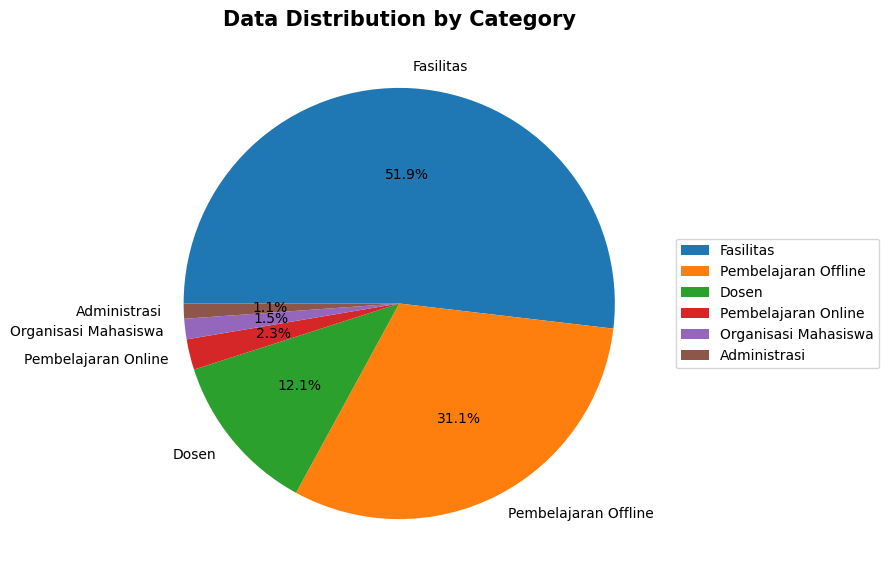

In [ ]:
plt.figure(figsize = (7, 7))
plt.pie(data_fix['category'].value_counts(), labels = data_fix['category'].value_counts().index, autopct = '%1.1f%%', startangle=180, counterclock=False)
plt.legend(data_fix['category'].value_counts().index, loc="center left", bbox_to_anchor=(1, 0.5))
plt.title("Data Distribution by Category", fontsize = 15, fontweight= "bold")
plt.show()

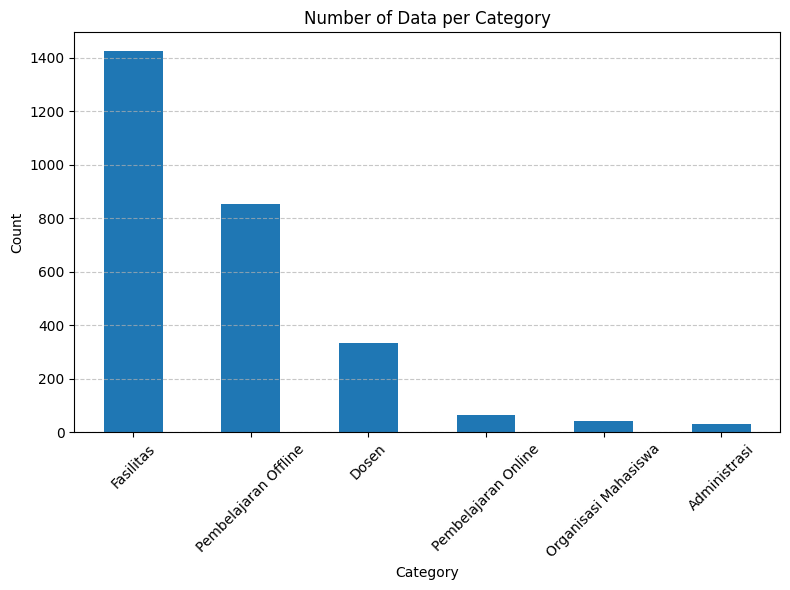

In [ ]:
plt.figure(figsize=(8, 6))
category_counts.plot(kind='bar')
plt.title('Number of Data per Category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# Path langsung ke lokasi file di Google Drive
file_path = '/content/drive/MyDrive/Aspect Category Sentiment Analysis/Dataset/dataset_category.csv'  # Ganti dengan path sesuai kebutuhan Anda

# Ekspor DataFrame ke CSV
data_fix.to_csv(file_path, index=False)

In [ ]:
data_sent = data_fix

# Sentiment Polarity Labelling

In [ ]:
import torch.nn.functional as F

# Muat model dan tokenizer IndoBERT
sentiment_tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-large-p1")
sentiment_model = AutoModelForSequenceClassification.from_pretrained("indobenchmark/indobert-large-p1")

# Muat INSET lexicon dari file .tsv
positive_lexicon = pd.read_csv('/content/drive/MyDrive/Aspect Category Sentiment Analysis/positive.tsv', sep='\t', header=None)
negative_lexicon = pd.read_csv('/content/drive/MyDrive/Aspect Category Sentiment Analysis/negative.tsv', sep='\t', header=None)

# Konversi ke set untuk pencarian cepat
positive_words = set(positive_lexicon[0].str.lower().tolist())
negative_words = set(negative_lexicon[0].str.lower().tolist())

# Fungsi untuk analisis sentimen dengan INSET dan pembobotan
def analyze_sentiment_with_inset(text):
    # Analisis sentimen menggunakan IndoBERT
    inputs = sentiment_tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = sentiment_model(**inputs)
    logits = outputs.logits
    probs = F.softmax(logits, dim=-1)
    sentiment_score = torch.argmax(probs, dim=-1).item()  # 0: Negatif, 1: Netral, 2: Positif

    # Hitung jumlah kata positif dan negatif menggunakan INSET
    words = text.lower().split()
    positive_count = sum(1 for word in words if word in positive_words)
    negative_count = sum(1 for word in words if word in negative_words)

    # Penyesuaian skor berdasarkan INSET
    if negative_count > positive_count:
        sentiment_score = max(0, sentiment_score - 1)  # Geser ke negatif jika lebih banyak kata negatif
    elif positive_count > negative_count:
        sentiment_score = min(2, sentiment_score + 1)  # Geser ke positif jika lebih banyak kata positif

    # Interpretasikan skor
    if sentiment_score == 0:
        return "Negative"
    elif sentiment_score == 1:
        return "Neutral"
    else:
        return "Positive"

# Terapkan analisis sentimen
data_sent['polarity'] = data_sent['opinion_stemmer'].apply(analyze_sentiment_with_inset)

# Tampilkan hasil
display(data_sent)

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-large-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


,opinion_tokenized,opinion_stemmer,category,polarity
0,"[mohon, wifi, gedung, d, mohon, luaskan, jangk...",mohon wifi gedung d mohon luas jangkau nya lan...,Dosen,Positive
1,"[toilet, gedung, terkadang, memiliki, sabun, t...",toilet gedung terkadang milik sabun tempat jam...,Pembelajaran Offline,Positive
2,"[wifi, gedung, h, gedung, d, sinyal, nya, kura...",wifi gedung h gedung d sinyal nya kurang baik ...,Fasilitas,Positive
3,"[buat, kulino, dosen, mengerti, cara, pengguna...",buat kulino dosen erti cara guna nya dapat mat...,Pembelajaran Offline,Positive
4,"[berharap, beberapa, dosen, memperbaiki, kebia...",harap beberapa dosen baik biasa datang tepat w...,Dosen,Negative
...,...,...,...,...
2743,"[salah, satu, dosen, cukup, sepuh, jadi, kuran...",salah satu dosen cukup sepuh jadi kurang jelas...,Dosen,Positive
2744,"[sebaik, nya, pembelajaran, online, diganti, o...",baik nya ajar online ganti offline semua,Pembelajaran Offline,Positive
2745,"[pembelajaran, online, kurang, efektif, dilaku...",ajar online kurang efektif laku karena fokus m...,Dosen,Negative
2746,"[ketidakhadiran, dipermudah, akses]",ketidakhadiran mudah akses,Fasilitas,Positive


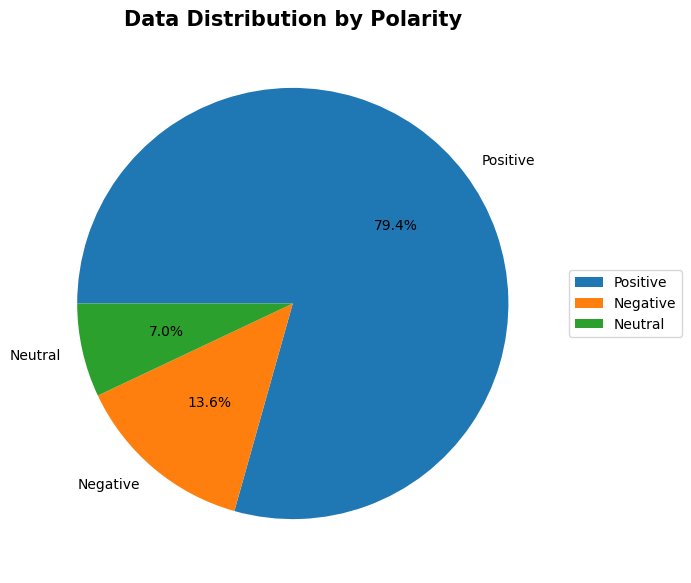

In [ ]:
plt.figure(figsize = (7, 7))
plt.pie(data_sent['polarity'].value_counts(), labels = data_sent['polarity'].value_counts().index, autopct = '%1.1f%%', startangle=180, counterclock=False)
plt.legend(data_sent['polarity'].value_counts().index, loc="center left", bbox_to_anchor=(1, 0.5))
plt.title("Data Distribution by Polarity", fontsize = 15, fontweight= "bold")
plt.show()

In [ ]:
polarity_counts = data_sent['polarity'].value_counts()
polarity_counts

,count
polarity,
Positive,2181
Negative,374
Neutral,193


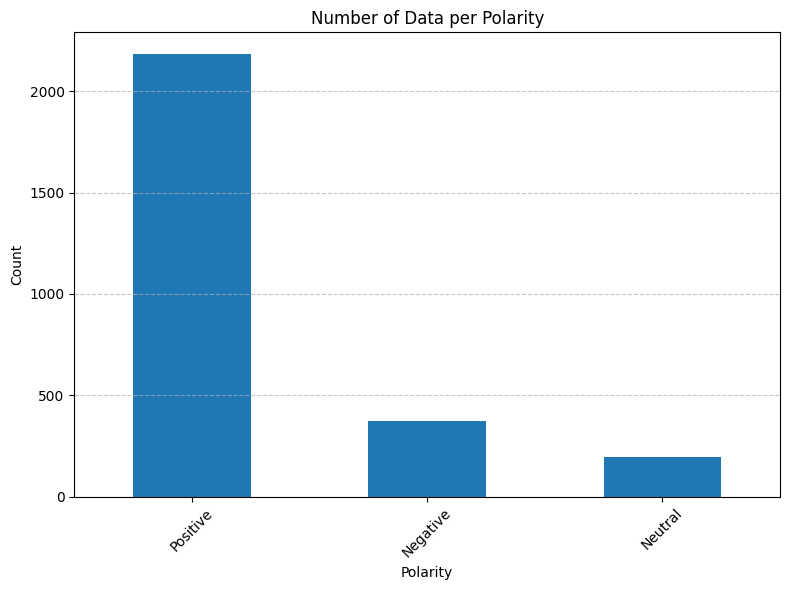

In [ ]:
plt.figure(figsize=(8, 6))
polarity_counts.plot(kind='bar')
plt.title('Number of Data per Polarity')
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Save dataset

In [ ]:
# Path langsung ke lokasi file di Google Drive
file_path = '/content/drive/MyDrive/Aspect Category Sentiment Analysis/Dataset/dataset_polarity_before.csv'  # Ganti dengan path sesuai kebutuhan Anda

# Ekspor DataFrame ke CSV
data_sent.to_csv(file_path, index=False)

# Oversampling

In [ ]:
data_model = data_sent.copy()
display(data_model)

,opinion_tokenized,opinion_stemmer,category,polarity
0,"[mohon, wifi, gedung, d, mohon, luaskan, jangk...",mohon wifi gedung d mohon luas jangkau nya lan...,Dosen,Positive
1,"[toilet, gedung, terkadang, memiliki, sabun, t...",toilet gedung terkadang milik sabun tempat jam...,Pembelajaran Offline,Positive
2,"[wifi, gedung, h, gedung, d, sinyal, nya, kura...",wifi gedung h gedung d sinyal nya kurang baik ...,Fasilitas,Positive
3,"[buat, kulino, dosen, mengerti, cara, pengguna...",buat kulino dosen erti cara guna nya dapat mat...,Pembelajaran Offline,Positive
4,"[berharap, beberapa, dosen, memperbaiki, kebia...",harap beberapa dosen baik biasa datang tepat w...,Dosen,Negative
...,...,...,...,...
2743,"[salah, satu, dosen, cukup, sepuh, jadi, kuran...",salah satu dosen cukup sepuh jadi kurang jelas...,Dosen,Positive
2744,"[sebaik, nya, pembelajaran, online, diganti, o...",baik nya ajar online ganti offline semua,Pembelajaran Offline,Positive
2745,"[pembelajaran, online, kurang, efektif, dilaku...",ajar online kurang efektif laku karena fokus m...,Dosen,Negative
2746,"[ketidakhadiran, dipermudah, akses]",ketidakhadiran mudah akses,Fasilitas,Positive


In [ ]:
label_encoder = LabelEncoder()
data_model['polarity_encoded'] = label_encoder.fit_transform(data_model['polarity'])

In [ ]:
# Oversampling menggunakan RandomOverSampler
oversampler = RandomOverSampler(random_state=42)
X_balanced, y_balanced = oversampler.fit_resample(
    data_model[['opinion_tokenized', 'opinion_stemmer', 'category']],  # Fitur teks
    data_model['polarity_encoded']  # Label kategori (encoded)
)

# Buat DataFrame dari hasil oversampling
data_model_balanced = pd.DataFrame(X_balanced, columns=['opinion_tokenized', 'opinion_stemmer', 'category'])
data_model_balanced['polarity_encoded'] = y_balanced

# Mapping kembali label encoded ke nama asli 'polarity'
label_mapping = {index: label for index, label in enumerate(label_encoder.classes_)}
data_model_balanced['polarity'] = data_model_balanced['polarity_encoded'].map(label_mapping)

# Simpan kembali dalam data_model
data_model = data_model_balanced
display(data_model)

,opinion_tokenized,opinion_stemmer,category,polarity_encoded,polarity
0,"[mohon, wifi, gedung, d, mohon, luaskan, jangk...",mohon wifi gedung d mohon luas jangkau nya lan...,Dosen,2,Positive
1,"[toilet, gedung, terkadang, memiliki, sabun, t...",toilet gedung terkadang milik sabun tempat jam...,Pembelajaran Offline,2,Positive
2,"[wifi, gedung, h, gedung, d, sinyal, nya, kura...",wifi gedung h gedung d sinyal nya kurang baik ...,Fasilitas,2,Positive
3,"[buat, kulino, dosen, mengerti, cara, pengguna...",buat kulino dosen erti cara guna nya dapat mat...,Pembelajaran Offline,2,Positive
4,"[berharap, beberapa, dosen, memperbaiki, kebia...",harap beberapa dosen baik biasa datang tepat w...,Dosen,0,Negative
...,...,...,...,...,...
6538,"[tempat, duduk, rooftop, h, kayu, nya, banyak,...",tempat duduk rooftop h kayu nya banyak copot n...,Fasilitas,1,Neutral
6539,"[pembayaran, uts, uas, sekarang, dipersulit]",bayar uts uas sekarang sulit,Pembelajaran Offline,1,Neutral
6540,"[tisu, toilet]",tisu toilet,Fasilitas,1,Neutral
6541,"[kursi, gedung, h, banyak, nyaman, meja, nya, ...",kursi gedung h banyak nyaman meja nya bengkok,Fasilitas,1,Neutral


In [ ]:
# # Ambil mapping dari encoded ke kategori
# label_mapping = {index: label for index, label in enumerate(label_encoder.classes_)}
# label_mapping

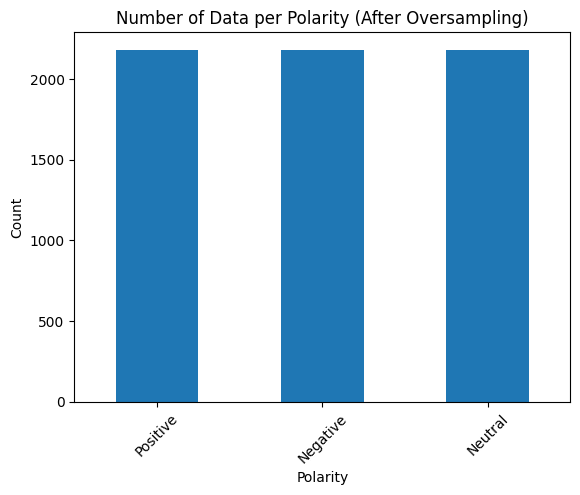

In [ ]:
data_model_balanced['polarity'].value_counts().plot(kind='bar')
plt.title('Number of Data per Polarity (After Oversampling)')
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [ ]:
data_model = data_model.drop(['polarity_encoded'], axis=1)

display(data_model)

,opinion_tokenized,opinion_stemmer,category,polarity
0,"[mohon, wifi, gedung, d, mohon, luaskan, jangk...",mohon wifi gedung d mohon luas jangkau nya lan...,Dosen,Positive
1,"[toilet, gedung, terkadang, memiliki, sabun, t...",toilet gedung terkadang milik sabun tempat jam...,Pembelajaran Offline,Positive
2,"[wifi, gedung, h, gedung, d, sinyal, nya, kura...",wifi gedung h gedung d sinyal nya kurang baik ...,Fasilitas,Positive
3,"[buat, kulino, dosen, mengerti, cara, pengguna...",buat kulino dosen erti cara guna nya dapat mat...,Pembelajaran Offline,Positive
4,"[berharap, beberapa, dosen, memperbaiki, kebia...",harap beberapa dosen baik biasa datang tepat w...,Dosen,Negative
...,...,...,...,...
6538,"[tempat, duduk, rooftop, h, kayu, nya, banyak,...",tempat duduk rooftop h kayu nya banyak copot n...,Fasilitas,Neutral
6539,"[pembayaran, uts, uas, sekarang, dipersulit]",bayar uts uas sekarang sulit,Pembelajaran Offline,Neutral
6540,"[tisu, toilet]",tisu toilet,Fasilitas,Neutral
6541,"[kursi, gedung, h, banyak, nyaman, meja, nya, ...",kursi gedung h banyak nyaman meja nya bengkok,Fasilitas,Neutral


# Splitting Data

In [ ]:
# Replace None values in 'category' with a string placeholder, like 'Unknown'
train_data, val_data = train_test_split(
    data_model.fillna({'polarity': 'Unknown'}),  # Replace None with 'Unknown'
    test_size=0.20,
    stratify=data_model['polarity'].fillna('Unknown'),  # Replace None with 'Unknown' for stratify
    random_state=42
)

display(train_data)

,opinion_tokenized,opinion_stemmer,category,polarity
1790,"[buat, gedung, h, kursi, nya, banyak, rusak, m...",buat gedung h kursi nya banyak rusak mohon ganti,Fasilitas,Positive
3627,"[permisi, ijin, meyampaikan, kritik, sini, men...",permisi ijin meyampaikan kritik sini kritik bi...,Pembelajaran Offline,Negative
3470,"[informasi, pemindahan, kelas, kurang, tersamp...",informasi pindah kelas kurang sampai baik,Pembelajaran Offline,Negative
2483,"[kem, ormawa, gudang, bauu, bangett, jadi, sar...",kem ormawa gudang bauu bangett jadi sarang kuc...,Fasilitas,Positive
5406,"[turunkan, harga, sks]",turun harga sks,Pembelajaran Offline,Neutral
...,...,...,...,...
3917,"[mohon, bapak, dekan, dosen, mengajar, nya, ou...",mohon bapak dekan dosen ajar nya out of the to...,Dosen,Negative
4111,"[tahu, beberapa, dosen, mengajar, sks, kulino,...",tahu beberapa dosen ajar sks kulino jelas,Pembelajaran Offline,Negative
3900,"[fasilitas, gedung, h, mungkin, ditambahkan, g...",fasilitas gedung h mungkin tambah galon air mi...,Fasilitas,Negative
58,"[fasilitas, komputer, gedung, d, banyak, kuran...",fasilitas komputer gedung d banyak kurang pada...,Pembelajaran Offline,Positive


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5234 entries, 1790 to 1243
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   opinion_tokenized  5234 non-null   object
 1   opinion_stemmer    5234 non-null   object
 2   category           5203 non-null   object
 3   polarity           5234 non-null   object
dtypes: object(4)
memory usage: 204.5+ KB


In [ ]:
val_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1309 entries, 809 to 902
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   opinion_tokenized  1309 non-null   object
 1   opinion_stemmer    1309 non-null   object
 2   category           1305 non-null   object
 3   polarity           1309 non-null   object
dtypes: object(4)
memory usage: 51.1+ KB


In [ ]:
val_data, test_data = train_test_split(
    val_data,
    test_size=0.10,
    stratify=val_data['polarity'],
    random_state=42
)

In [ ]:
val_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1178 entries, 420 to 4711
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   opinion_tokenized  1178 non-null   object
 1   opinion_stemmer    1178 non-null   object
 2   category           1175 non-null   object
 3   polarity           1178 non-null   object
dtypes: object(4)
memory usage: 46.0+ KB


In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 131 entries, 5131 to 790
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   opinion_tokenized  131 non-null    object
 1   opinion_stemmer    131 non-null    object
 2   category           130 non-null    object
 3   polarity           131 non-null    object
dtypes: object(4)
memory usage: 5.1+ KB


In [ ]:
# test_data = test_data.drop(columns=['opinion'])
display(test_data)

,opinion_tokenized,opinion_stemmer,category,polarity
5131,"[materi, pembelajaran, diperbarui, sesuai, dib...",materi ajar baru sesuai butuh industri react js,Pembelajaran Offline,Neutral
4721,"[beberapa, meja, kursi, h, lumayan, rusak, kur...",beberapa meja kursi h lumayan rusak kurang nya...,Fasilitas,Neutral
3033,"[bang, ku, banyak, rusak, meja, bangku, sesuai...",bang ku banyak rusak meja bangku sesuai lebih ...,Pembelajaran Offline,Negative
1407,"[semoga, pas, pemilihan, krs, an, ditampilin, ...",moga pas pilih krs an ditampilin dosen ajar da...,Dosen,Positive
4216,"[berikan, fasilitas, kem, layak, ormawa, fik, ...",ikan fasilitas kem layak ormawa fik lebar ruan...,Organisasi Mahasiswa,Negative
...,...,...,...,...
2442,"[butuh, atap, parkiran]",butuh atap parkir,Fasilitas,Neutral
2421,"[ac, d, dingin]",ac d dingin,Fasilitas,Positive
6312,"[fasilitas, mohon, dipertimbangkan, disediakan...",fasilitas mohon timbang sedia layak branding a...,Fasilitas,Neutral
3959,"[sinyal, wifi, kampus, d, enggak, kelas, susah...",sinyal wifi kampus d enggak kelas susah jangkau,Fasilitas,Negative


# Sentiment Polarity Analysis

In [ ]:
# Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p2")
model = BertForSequenceClassification.from_pretrained("indobenchmark/indobert-base-p2", num_labels=3)

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples['opinion_stemmer'], padding="max_length", truncation=True, max_length=128)

In [ ]:
# Convert data to Hugging Face Dataset format
train_dataset = Dataset.from_pandas(train_data)
val_dataset = Dataset.from_pandas(val_data)
test_dataset = Dataset.from_pandas(test_data)

In [ ]:
train_dataset = train_dataset.rename_column("polarity", "labels")
val_dataset = val_dataset.rename_column("polarity", "labels")

In [ ]:
print(train_dataset["labels"][:5])  # Lihat beberapa nilai awal

['Positive', 'Negative', 'Negative', 'Positive', 'Neutral']


In [ ]:
label_mapping = {"Negative": 0, "Neutral": 1, "Positive": 2}

train_dataset = train_dataset.map(lambda x: {"labels": label_mapping[x["labels"]]})
val_dataset = val_dataset.map(lambda x: {"labels": label_mapping[x["labels"]]})

Map:   0%|          | 0/5234 [00:00<?, ? examples/s]

Map:   0%|          | 0/1178 [00:00<?, ? examples/s]

In [ ]:
print(train_dataset["labels"][:5])

[2, 0, 0, 2, 1]


In [ ]:
print(type(train_dataset["labels"][0]))

<class 'int'>


In [ ]:
# Tokenize datasets
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/5234 [00:00<?, ? examples/s]

Map:   0%|          | 0/1178 [00:00<?, ? examples/s]

Map:   0%|          | 0/131 [00:00<?, ? examples/s]

In [ ]:
# Format datasets for PyTorch
train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
val_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask"])

In [ ]:
print(train_dataset.column_names)

['opinion_tokenized', 'opinion_stemmer', 'category', 'labels', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask']


In [ ]:
# Define compute_metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="weighted")
    accuracy = accuracy_score(labels, predictions)
    return {
        "accuracy": accuracy,
        "f1": f1,
        "precision": precision,
        "recall": recall,
    }

In [ ]:
# Define training arguments manually
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,  # Set manually
    per_device_train_batch_size=16,  # Set manually
    num_train_epochs=10,  # Set manually
    weight_decay=0.01,
    save_total_limit=2,
    load_best_model_at_end=True,
    logging_dir='./logs',
    logging_steps=30,
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

<ipython-input-73-d411c8a07fbe>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.247900,0.250426,0.911715,0.911769,0.913005,0.911715
2,0.118800,0.180813,0.958404,0.958126,0.960761,0.958404
3,0.112000,0.110764,0.970289,0.970088,0.970736,0.970289
4,0.067800,0.130213,0.976231,0.976001,0.977054,0.976231
5,0.030000,0.117173,0.979626,0.979496,0.980374,0.979626
6,0.017900,0.098986,0.987267,0.987247,0.987679,0.987267
7,0.000100,0.107728,0.982173,0.982053,0.982663,0.982173
8,0.000100,0.144775,0.979626,0.979463,0.980247,0.979626
9,0.001500,0.120036,0.982173,0.982046,0.982639,0.982173
10,0.000100,0.136537,0.980475,0.980322,0.981032,0.980475


TrainOutput(global_step=3280, training_loss=0.09093492928844105, metrics={'train_runtime': 2377.0899, 'train_samples_per_second': 22.019, 'train_steps_per_second': 1.38, 'total_flos': 3442839070970880.0, 'train_loss': 0.09093492928844105, 'epoch': 10.0})

In [ ]:
# Ekstrak log pelatihan
logs = trainer.state.log_history
logs_df = pd.DataFrame(logs)

# Tampilkan log yang tersedia
logs_df

,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_accuracy,eval_f1,eval_precision,eval_recall,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,1.0478,6.398075,4.954268e-05,0.091463,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.9243,14.684480,4.908537e-05,0.182927,60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.7471,11.866293,4.862805e-05,0.274390,90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.5709,7.713118,4.817073e-05,0.365854,120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.5348,23.528433,4.771341e-05,0.457317,150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,0.0001,0.000825,1.067073e-06,9.786585,3210,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
116,0.0001,0.000902,6.097561e-07,9.878049,3240,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
117,0.0001,0.053476,1.524390e-07,9.969512,3270,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
118,NaN,NaN,NaN,10.000000,3280,0.136537,0.980475,0.980322,0.981032,0.980475,8.1014,145.408,18.269,NaN,NaN,NaN,NaN,NaN


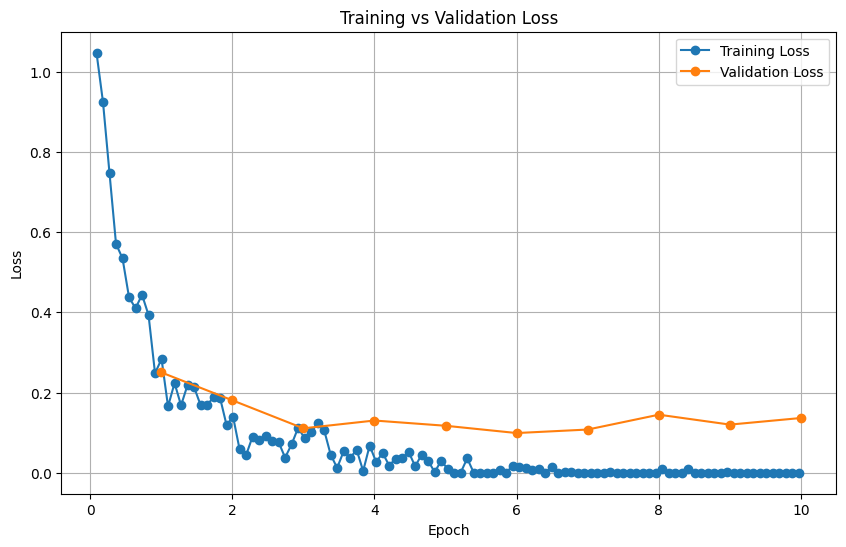

In [ ]:
# Filter training loss dan validation loss dari log
train_loss = logs_df[logs_df["loss"].notnull()][["epoch", "loss"]]
val_loss = logs_df[logs_df["eval_loss"].notnull()][["epoch", "eval_loss"]]

# Plot training loss dan validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_loss["epoch"], train_loss["loss"], label="Training Loss", marker="o")
plt.plot(val_loss["epoch"], val_loss["eval_loss"], label="Validation Loss", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

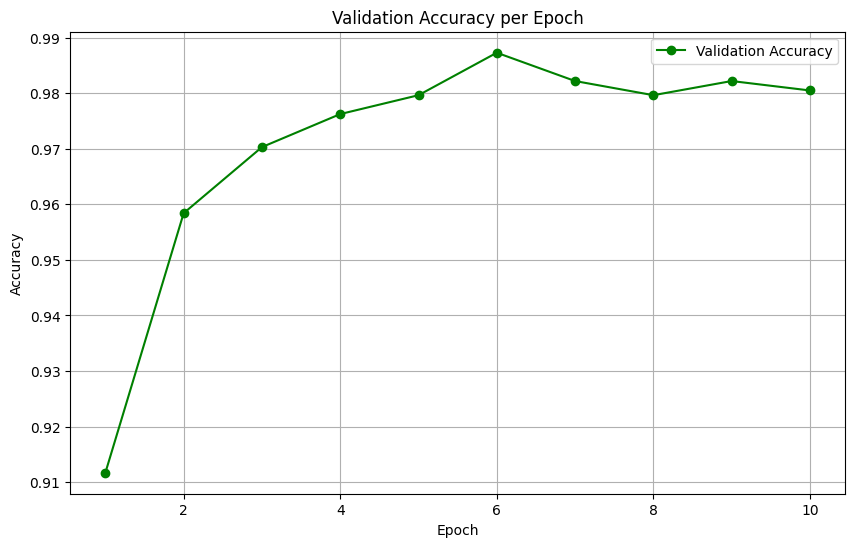

In [ ]:
# Extract validation accuracy from logs
val_accuracy = logs_df[logs_df["eval_accuracy"].notnull()][["epoch", "eval_accuracy"]]

# Plot validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(val_accuracy["epoch"], val_accuracy["eval_accuracy"], label="Validation Accuracy", marker="o", color='green')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy per Epoch")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
val_results = trainer.evaluate(val_dataset)
print("Validation Results:", val_results)

Validation Results: {'eval_loss': 0.0989857092499733, 'eval_accuracy': 0.9872665534804754, 'eval_f1': 0.9872474770328282, 'eval_precision': 0.9876785201118469, 'eval_recall': 0.9872665534804754, 'eval_runtime': 8.2289, 'eval_samples_per_second': 143.154, 'eval_steps_per_second': 17.985, 'epoch': 10.0}


In [ ]:
val_results

{'eval_loss': 0.0989857092499733,
 'eval_accuracy': 0.9872665534804754,
 'eval_f1': 0.9872474770328282,
 'eval_precision': 0.9876785201118469,
 'eval_recall': 0.9872665534804754,
 'eval_runtime': 8.2289,
 'eval_samples_per_second': 143.154,
 'eval_steps_per_second': 17.985,
 'epoch': 10.0}

In [ ]:
# Predict on test dataset
test_predictions = trainer.predict(test_dataset)
predicted_labels = np.argmax(test_predictions.predictions, axis=1)

# Display predictions
print(predicted_labels)

[1 1 0 2 0 1 0 0 0 2 2 0 1 2 1 2 0 2 0 0 1 0 2 0 1 0 2 2 1 0 1 0 2 0 0 0 1
 1 1 2 2 1 0 2 1 1 0 2 1 1 2 1 0 0 1 1 1 2 1 2 2 2 1 2 2 0 1 2 1 2 1 0 0 0
 1 2 2 1 0 0 0 0 2 0 1 2 0 0 1 0 0 2 0 2 0 2 1 2 0 1 1 0 1 1 1 1 1 1 0 2 2
 2 1 2 2 2 2 0 0 1 0 2 2 0 2 0 1 2 1 0 2]


In [ ]:
# Convert predicted_labels to a list
predicted_labels = predicted_labels.tolist()

# Add the predicted_labels to the test_dataset using Dataset.map
test_dataset = test_dataset.map(lambda x, idx: {"predicted_labels": predicted_labels[idx]}, with_indices=True)

# Convert the test dataset to a DataFrame for easier viewing
test_df = test_dataset.to_pandas()

# Display the DataFrame
display(test_df)

Map:   0%|          | 0/131 [00:00<?, ? examples/s]

                                     opinion_tokenized  \
0    [materi, pembelajaran, diperbarui, sesuai, dib...   
1    [beberapa, meja, kursi, h, lumayan, rusak, kur...   
2    [bang, ku, banyak, rusak, meja, bangku, sesuai...   
3    [semoga, pas, pemilihan, krs, an, ditampilin, ...   
4    [berikan, fasilitas, kem, layak, ormawa, fik, ...   
..                                                 ...   
126                            [butuh, atap, parkiran]   
127                                    [ac, d, dingin]   
128  [fasilitas, mohon, dipertimbangkan, disediakan...   
129  [sinyal, wifi, kampus, d, enggak, kelas, susah...   
130                      [mungkin, materi, restricted]   

                                       opinion_stemmer              category  \
0      materi ajar baru sesuai butuh industri react js  Pembelajaran Offline   
1    beberapa meja kursi h lumayan rusak kurang nya...             Fasilitas   
2    bang ku banyak rusak meja bangku sesuai lebih ...  Pembela

In [ ]:
display(test_df)

,opinion_tokenized,opinion_stemmer,category,polarity,__index_level_0__,input_ids,token_type_ids,attention_mask,predicted_labels
0,"[materi, pembelajaran, diperbarui, sesuai, dib...",materi ajar baru sesuai butuh industri react js,Pembelajaran Offline,Neutral,5131,"[2, 1616, 9411, 440, 786, 2655, 1934, 520, 890...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, ...",1
1,"[beberapa, meja, kursi, h, lumayan, rusak, kur...",beberapa meja kursi h lumayan rusak kurang nya...,Fasilitas,Neutral,4721,"[2, 388, 3400, 3544, 40, 4942, 3655, 1057, 238...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, ...",1
2,"[bang, ku, banyak, rusak, meja, bangku, sesuai...",bang ku banyak rusak meja bangku sesuai lebih ...,Pembelajaran Offline,Negative,3033,"[2, 1719, 425, 271, 3655, 3400, 10757, 786, 21...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0
3,"[semoga, pas, pemilihan, krs, an, ditampilin, ...",moga pas pilih krs an ditampilin dosen ajar da...,Dosen,Positive,1407,"[2, 16983, 280, 959, 518, 30362, 223, 18154, 3...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2
4,"[berikan, fasilitas, kem, layak, ormawa, fik, ...",ikan fasilitas kem layak ormawa fik lebar ruan...,Organisasi Mahasiswa,Negative,4216,"[2, 1615, 2138, 198, 4102, 13025, 2060, 10710,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0
...,...,...,...,...,...,...,...,...,...
126,"[butuh, atap, parkiran]",butuh atap parkir,Fasilitas,Neutral,2442,"[2, 2655, 5948, 5222, 3, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
127,"[ac, d, dingin]",ac d dingin,Fasilitas,Positive,2421,"[2, 627, 6, 3522, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2
128,"[fasilitas, mohon, dipertimbangkan, disediakan...",fasilitas mohon timbang sedia layak branding a...,Fasilitas,Neutral,6312,"[2, 2138, 2903, 28469, 17176, 4102, 22190, 120...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
129,"[sinyal, wifi, kampus, d, enggak, kelas, susah...",sinyal wifi kampus d enggak kelas susah jangkau,Fasilitas,Negative,3959,"[2, 5711, 6007, 4281, 6, 6878, 1194, 3684, 276...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ...",0


In [ ]:
print(test_dataset.column_names)

['opinion_tokenized', 'opinion_stemmer', 'category', 'polarity', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask', 'predicted_labels']


In [ ]:
test_dataset = Dataset.from_pandas(test_data)
label_mapping = {"Negative": 0, "Neutral": 1, "Positive": 2}
test_dataset = test_dataset.map(lambda x: {"labels": label_mapping[x["polarity"]]})

Map:   0%|          | 0/131 [00:00<?, ? examples/s]

In [ ]:
test_dataset = test_dataset.map(lambda x, idx: {"predicted_labels": predicted_labels[idx]}, with_indices=True)

Map:   0%|          | 0/131 [00:00<?, ? examples/s]

In [ ]:
test_df = test_dataset.to_pandas()
test_df.head()


,opinion_tokenized,opinion_stemmer,category,polarity,__index_level_0__,labels,predicted_labels
0,"[materi, pembelajaran, diperbarui, sesuai, dib...",materi ajar baru sesuai butuh industri react js,Pembelajaran Offline,Neutral,5131,1,1
1,"[beberapa, meja, kursi, h, lumayan, rusak, kur...",beberapa meja kursi h lumayan rusak kurang nya...,Fasilitas,Neutral,4721,1,1
2,"[bang, ku, banyak, rusak, meja, bangku, sesuai...",bang ku banyak rusak meja bangku sesuai lebih ...,Pembelajaran Offline,Negative,3033,0,0
3,"[semoga, pas, pemilihan, krs, an, ditampilin, ...",moga pas pilih krs an ditampilin dosen ajar da...,Dosen,Positive,1407,2,2
4,"[berikan, fasilitas, kem, layak, ormawa, fik, ...",ikan fasilitas kem layak ormawa fik lebar ruan...,Organisasi Mahasiswa,Negative,4216,0,0


<Figure size 800x600 with 0 Axes>

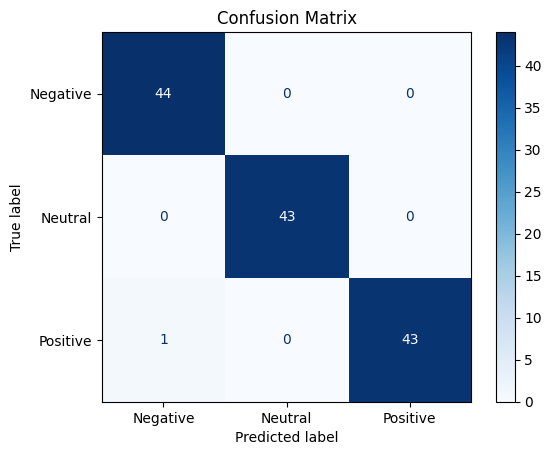

In [ ]:
cm = confusion_matrix(test_df["labels"], test_df["predicted_labels"], labels=[0, 1, 2])
cmd = ConfusionMatrixDisplay(cm, display_labels=["Negative", "Neutral", "Positive"])

plt.figure(figsize=(8, 6))
cmd.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix")
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Classification Report
print("Classification Report:")
print(classification_report(test_df["labels"], test_df["predicted_labels"], target_names=["Negative", "Neutral", "Positive"]))

# Additional Metrics
accuracy = accuracy_score(test_df["labels"], test_df["predicted_labels"])
precision = precision_score(test_df["labels"], test_df["predicted_labels"], average='weighted')
recall = recall_score(test_df["labels"], test_df["predicted_labels"], average='weighted')
f1 = f1_score(test_df["labels"], test_df["predicted_labels"], average='weighted')

print("\nMetrics Summary:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Classification Report:


NameError: name 'test_df' is not defined